*Sign Language - Machine Learning*

---

Seminarski rad u sklopu kursa Mašinsko učenje - Matematički fakultet, Univerzitet u Beogradu

**Autori**  
Nikola Dimić i Zorana Gajić

**Opis projekta**  
 Cilj ovog projekta jeste da se konstruiše model za klasifikaciju slika znakovnog jezika kako bismo olakšali njegovo učenje i razumevanje.

**Baza podataka**  
Baza podataka sadrži 3000 slika za svako slovo. Znakovi su slikani iz različitih uglova i pod različitim osvetljenjem, kako bi se dobio što precizniji model. Link do baze je [ovde](https://www.kaggle.com/paultimothymooney/interpret-sign-language-with-deep-learning/data).



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!unzip drive/My\ Drive/input.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/__MACOSX/input/asl-alphabet/asl_alphabet_train/W/._W545.jpg  
  inflating: data/input/asl-alphabet/asl_alphabet_train/W/W2801.jpg  
  inflating: data/__MACOSX/input/asl-alphabet/asl_alphabet_train/W/._W2801.jpg  
  inflating: data/input/asl-alphabet/asl_alphabet_train/W/W73.jpg  
  inflating: data/__MACOSX/input/asl-alphabet/asl_alphabet_train/W/._W73.jpg  
  inflating: data/input/asl-alphabet/asl_alphabet_train/W/W223.jpg  
  inflating: data/__MACOSX/input/asl-alphabet/asl_alphabet_train/W/._W223.jpg  
  inflating: data/input/asl-alphabet/asl_alphabet_train/W/W2197.jpg  
  inflating: data/__MACOSX/input/asl-alphabet/asl_alphabet_train/W/._W2197.jpg  
  inflating: data/input/asl-alphabet/asl_alphabet_train/W/W2829.jpg  
  inflating: data/__MACOSX/input/asl-alphabet/asl_alphabet_train/W/._W2829.jpg  
  inflating: data/input/asl-alphabet/asl_alphabet_train/W/W579.jpg  
  inflating: data/__MACOSX/input/a

**Neophodne biblioteke**

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import random

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras import utils

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

**Pretprocesiranje slika**

Slike znakovnog jezika nalaze se u datotekama razvrstane po slovima. Prilikom učitavanja svake od datoteka, slika je obrađena u skladu sa potrebama mreže koja se trenira. Tako je svaka slika smanjena ili povećana u skladu sa odgovarajućim dimenzijama. Svakoj slici dodeljena je klasa u skladu sa datotekom u kojoj se nalaze, s tim što su klase konvertovane iz slovnog u brojevni zapis pa tako su slova *A,B...Z* redom označena rednim brojevima slova u abecedi (*0,1..25*), dok su specijalni karakteri *del*, *nothing* i *space* označeni brojevima *26,27,28* respektivno. Nakon obrade slika i pridruživanja klasa, ispisane su specifikacije skupa podataka, kao i dimenzije matrica kojima su opisane slike. 

In [ ]:
def letterToNumber(letter):
    if(len(letter) == 1):
        letterNum = ord(letter.lower()) - 97
    elif(letter == 'del'):
        letterNum = 26
    elif(letter == 'nothing'):
        letterNum = 27
    elif(letter == 'space'):
        letterNum = 28
    else:
        letterNum = 29
    return letterNum

def proccessImage(imageFile, size=(200,200), color = True):
    color = 3 if color else 1
    resizedImage = resize(imageFile, (size[0], size[1], color), anti_aliasing=True)
    return np.asarray(resizedImage)

def resizeData(X, size=(200,200), color = True):
    Xnew = map(lambda img: proccessImage(img,size,color), X)
    return list(Xnew)

def logData(imageColor, imageSize, imagesPerLetter, item):
    print("Extracted data with the following specifications:")
    print("--------------------------------------------------")
    print("color: " + str(imageColor))
    print("size: " + str(imageSize))
    print("images per letter: " + str(imagesPerLetter))
    print("output shape: " + str(item.shape))

def exctractDataFromFiles(file, imageColor = True, imageSize = (200,200), imagesPerLetter='all'):
    color = 1 if imageColor else 0
    X = []
    y = []
    for folderName in os.listdir(file):
        if not folderName.startswith('.'):
            classLetter = folderName
            classNum = letterToNumber(classLetter)
            fullFolderName = file+folderName
            listOfImages = os.listdir(fullFolderName)
            random.shuffle(listOfImages)
            numOfImages = len(listOfImages) if imagesPerLetter == 'all' else imagesPerLetter
            
            for imageName in tqdm(listOfImages[0:numOfImages]):
                fullImageName = fullFolderName + "/" + imageName
                imageFile = cv2.imread(fullImageName, color)
                resizedImage = proccessImage(imageFile, imageSize, color)   
                X.append(resizedImage)
                y.append(classNum)
    X = np.asarray(X)
    y = np.asarray(y)
    logData(imageColor, imageSize, imagesPerLetter, X[0])
    return X,y


In [ ]:
!ls

data  drive  sample_data


In [ ]:
trainFolder = "./data/input/asl-alphabet/asl_alphabet_train/"
#testFolder =  "../input/asl-alphabet/asl_alphabet_test/"

X, y = exctractDataFromFiles(trainFolder, imageColor = True, imageSize = (200,200), imagesPerLetter = 100)

100%|██████████| 100/100 [00:01<00:00, 89.47it/s]


Extracted data with the following specifications:
--------------------------------------------------
color: True
size: (200, 200)
images per letter: 100
output shape: (200, 200, 3)


**Prikaz slike**


In [ ]:
testImage = cv2.imread("../input/asl-alphabet/asl_alphabet_train/A/A1.jpg")
resizedTestImage = proccessImage(testImage, size=(50,50), color=True)
print(resizedTestImage.shape)
plt.imshow(resizedTestImage, cmap='gray')
plt.show()

**Pretprocesiranje ciljne promenljive**  
U sklopu transformacije ciljne promenljive je korišćeno `One-Hot encoding`, odnosno kodiranje koje kategoričkom atributu (ciljnoj promenljivoj) sa $k$ mogućih različitih vrednosti (gde je $k$ u našem slučaju vrednost 30) pridružuje $k$ novih promenljivih, a vrednostima kategoričke promenljive vrednosti indikatora.

0 &#8594; 1 0 0 0 ... 0  
1 &#8594; 0 1 0 0 ... 0  
2 &#8594; 0 0 1 0 ... 0  
...  
29 &#8594; 0 0 0 0 ... 0  

In [ ]:
numOfClasses = 30

In [ ]:
# One hot encoding of target variable
y = to_categorical(y, numOfClasses)

**Podela podataka na trening i test skup**  
Učitani podaci se dele na trening i test skup u odnosu *3:1*, s tim što se uz pomoć naglašenog parametra *stratify* čuva udeo ciljne promenljive iz originalnog skupa podataka.

In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1943, 200, 200, 3)
(957, 200, 200, 3)
(1943, 30)
(957, 30)


In [ ]:
!ls

data  drive  sample_data


In [ ]:
np.save("./data/Xtrain", X_train)
np.save("./data/Xtest", X_test)
print("X saved")
np.save("./data/Ytrain", y_train)
np.save("./data/Ytest", y_test)
print("Y saved")

X saved
Y saved


In [ ]:
X_train = np.load("./data/Xtrain.npy")
X_test = np.load("./data/Xtest.npy")
print("X loaded")
y_train = np.load("./data/Ytrain.npy")
y_test = np.load("./data/Ytest.npy")
print("Y loaded")

X loaded
Y loaded


**Početni model**  
Prvi pokušaj rešavanja problema je bila konvolutivna neuronska mreža sa arhitekturom sličnoj onoj prikazanoj na vežbama. Naime, korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *16* filtera, kernelom veličine *3x3*, uokvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.    
**2 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti i veličinom bloka *2x2*.  
**3 sloj:** Konvolucioni sloj sa *32* filtera, kernelom veličine *3x3*, uokvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.    
**4 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti i veličinom bloka *2x2*.  
**5 sloj:** Konvolucioni sloj sa *64* filtera, kernelom veličine *3x3*, uokvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.    
**6 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *1024* i ReLu aktivacionom funkcijom.  
Zatim tehnika regularizacije kojom isključujemo nasumično odabrane neurone i omogućavamo drugačiji protok podataka kroz mrežu *Dropout*.
**7 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom. 

In [ ]:
# DOBAR MODEL ZA COLOR 
# Training model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numOfClasses, activation='softmax'))

In [ ]:
# Model summary per layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)             

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **12**  
*Veličina paketića za treniranje* (engl. batch size): **128**  

Za evaluaciju mreže koristimo **preciznost**.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/100
122/122 [==============================] - 1s 10ms/step - loss: 2.6705 - accuracy: 0.2304 - val_loss: 1.6855 - val_accuracy: 0.5023
Epoch 2/100
122/122 [==============================] - 1s 8ms/step - loss: 1.3445 - accuracy: 0.5731 - val_loss: 0.8719 - val_accuracy: 0.7337
Epoch 3/100
122/122 [==============================] - 1s 8ms/step - loss: 0.7832 - accuracy: 0.7441 - val_loss: 0.5147 - val_accuracy: 0.8482
Epoch 4/100
122/122 [==============================] - 1s 8ms/step - loss: 0.4999 - accuracy: 0.8350 - val_loss: 0.3481 - val_accuracy: 0.8984
Epoch 5/100
122/122 [==============================] - 1s 8ms/step - loss: 0.3480 - accuracy: 0.8821 - val_loss: 0.2653 - val_accuracy: 0.9246
Epoch 6/100
122/122 [==============================] - 1s 8ms/step - loss: 0.2648 - accuracy: 0.9142 - val_loss: 0.1877 - val_accuracy: 0.9447
Epoch 7/100
122/122 [==============================] - 1s 8ms/step - loss: 0.2067 - accuracy: 0.9303 - val_loss: 0.1378 - val_accuracy: 0.958

In [ ]:
# Plotting loss/accuracy values of train and validation data during training model
def plot_loss_accuracy(epochs, history):
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
  plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
  plt.legend(loc='best')

  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
  plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
  plt.legend(loc='best')

Na sledećem zajedničkom grafiku je prikazana funkcija gubitka na skupu za treniranje i validaciju, a potom i funkcija preciznosti.

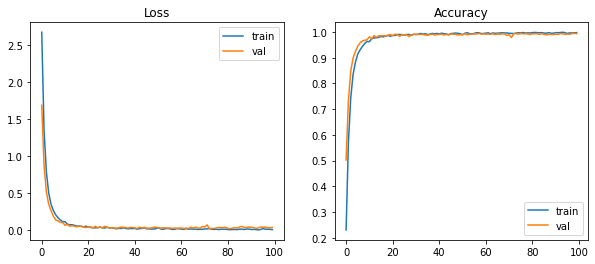

In [ ]:
plot_loss_accuracy(100, history)

In [ ]:
def show_classification_report(model, X_test, y_test):
  print(classification_report(np.argmax(y_test, axis=1), model.predict_classes(X_test)))

TODO

In [ ]:
show_classification_report(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       330
           1       1.00      1.00      1.00       330
           2       1.00      1.00      1.00       330
           3       0.98      1.00      0.99       330
           4       0.99      0.97      0.98       330
           5       1.00      1.00      1.00       330
           6       0.99      0.99      0.99       330
           7       0.99      0.99      0.99       330
           8       0.99      1.00      1.00       330
           9       0.99      0.99      0.99       330
          10       0.99      0.98      0.99       330
          11       1.00      1.00      1.00       330
          12       1.00      1.00      1.00       330
          13       1.00      1.00      1.00       330
          14       1.00      0.98      0.99       330
          15       1.00      0.99      0.99       330
          16       1.00      1.00      1.00       330
          17       0.98    

In [ ]:
# Evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03432227671146393
Test accuracy: 0.9936259388923645


**Model iz naučnog rada**  
Sledeći pokušaj rešavanja datog problema je bio uz pomoć pronađenog naučnog rada koji možete pogledati [ovde](https://) .  
Iako se skupovi podataka razlikuju, pokušali smo sa predloženim modelom: korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *16* filtera, kernelom veličine *2x2* i *ReLu* aktivacionom funkcijom.    
**2 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *2x2*, veličinom pomeraja *2x2* i uokvirenjem tako da veličina izlazne slike može biti istih dimenzija.  
**3 sloj:** Konvolucioni sloj sa *32* filtera, kernelom veličine *3x3* i *ReLu* aktivacionom funkcijom.    
**4 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *3x3*, veličinom pomeraja *3x3* i uokvirenjem tako da veličina izlazne slike može biti istih dimenzija.   
**5 sloj:** Konvolucioni sloj sa *64* filtera, kernelom veličine *5x5* i *ReLu* aktivacionom funkcijom.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.    
**6 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *128* i ReLu aktivacionom funkcijom.  
Zatim tehnika regularizacije kojom isključujemo nasumično odabrane neurone i omogućavamo drugačiji protok podataka kroz mrežu *Dropout*.
**7 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom. 

In [ ]:
# DOBAR MODEL ZA GRAYSCALE
# Training model
paper_model = Sequential()
paper_model.add(Conv2D(16, (2,2), input_shape=(50,50,1), activation='relu'))
paper_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
paper_model.add(Conv2D(32, (3,3), activation='relu'))
paper_model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))
paper_model.add(Conv2D(64, (5,5), activation='relu'))
paper_model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
paper_model.add(Flatten())
paper_model.add(Dense(128, activation='relu'))
paper_model.add(Dropout(0.2))
paper_model.add(Dense(numOfClasses, activation='softmax'))

In [ ]:
# Model summary per layers
paper_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 49, 49, 16)        80        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 23, 23, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 4, 64)          51264     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)               

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **50**  
*Veličina paketića za treniranje* (engl. batch size): **500**  

Za evaluaciju mreže koristimo **preciznost**.


In [ ]:
paper_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train model
paper_history = paper_model.fit(X_train, y_train,
                    batch_size=500,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/100
32/32 [==============================] - 1s 20ms/step - loss: 3.3796 - accuracy: 0.0472 - val_loss: 3.3201 - val_accuracy: 0.0983
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 3.1955 - accuracy: 0.1105 - val_loss: 2.9264 - val_accuracy: 0.1837
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 2.7575 - accuracy: 0.2005 - val_loss: 2.4065 - val_accuracy: 0.3222
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 2.3018 - accuracy: 0.3143 - val_loss: 2.0393 - val_accuracy: 0.3994
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 2.0255 - accuracy: 0.3742 - val_loss: 1.7910 - val_accuracy: 0.4725
Epoch 6/100
32/32 [==============================] - 0s 13ms/step - loss: 1.8052 - accuracy: 0.4366 - val_loss: 1.6066 - val_accuracy: 0.5167
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - loss: 1.6260 - accuracy: 0.4871 - val_loss: 1.4595 - val_accuracy: 0.5674
Epoch 

*Na sledećem zajedničkom grafiku je prikazana funkcija gubitka na skupu za treniranje i validaciju, a potom i funkcija preciznosti.*

In [ ]:
plot_loss_accuracy(50, paper_history)

**TODO**

In [ ]:
show_classification_report(paper_model, X_test, y_test)

In [ ]:
# Evaluate model
score = paper_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15175390243530273
Test accuracy: 0.9547544121742249


**VGG16 model**  
Sledeći pokušaj rešavanja datog problema je bio uz pomoć arhitekture VGG16 mreže. Korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *64* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**2 sloj:** Kao i prvi sloj.  
**3 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *2x2*, veličinom pomeraja *2x2*.  
**4 sloj:** Konvolucioni sloj sa *128* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**5 sloj:** Kao i četvrti sloj.   
**6 sloj:** Kao i treći sloj.     
**7 sloj:** Konvolucioni sloj sa *256* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**8 sloj:** Kao i sedmi sloj.  
**9 sloj:** Kao i sedmi sloj.  
**10 sloj:** Konvolucioni sloj sa *512* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**11 sloj:** Kao i deseti sloj.  
**12 sloj:** Kao i deseti sloj.
**13 sloj:** Kao i treći sloj.  
**14 sloj:** Kao i deseti sloj.  
**15 sloj:** Kao i deseti sloj.  
**16 sloj:** Kao i deseti sloj.  
**17 sloj:** Kao i treći sloj.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.  
**18 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *4096* i *ReLu* aktivacionom funkcijom. 
**19 sloj:** Kao i 18. sloj.  
**20 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom. 


In [ ]:
# VGG16 model
vgg16_model = Sequential()

vgg16_model.add(Conv2D(input_shape=(200,200,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
vgg16_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(units=4096, activation="relu"))
vgg16_model.add(Dense(units=4096, activation="relu"))
vgg16_model.add(Dense(units=numOfClasses, activation="softmax"))

In [ ]:
# Model summary per layers
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 256)       2

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **100**  
*Veličina paketića za treniranje* (engl. batch size): **128**  

Za evaluaciju mreže koristimo **preciznost**.

In [ ]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
vgg16_history = vgg16_model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/100
13/13 [==============================] - 10s 768ms/step - loss: 3.4343 - accuracy: 0.0238 - val_loss: 3.3984 - val_accuracy: 0.0180
Epoch 2/100
13/13 [==============================] - 9s 676ms/step - loss: 3.3873 - accuracy: 0.0386 - val_loss: 3.3979 - val_accuracy: 0.0180
Epoch 3/100
13/13 [==============================] - 9s 677ms/step - loss: 3.3799 - accuracy: 0.0367 - val_loss: 3.3909 - val_accuracy: 0.0334
Epoch 4/100
13/13 [==============================] - 9s 673ms/step - loss: 3.3769 - accuracy: 0.0373 - val_loss: 3.3934 - val_accuracy: 0.0206
Epoch 5/100
13/13 [==============================] - 9s 676ms/step - loss: 3.3742 - accuracy: 0.0405 - val_loss: 3.3995 - val_accuracy: 0.0231
Epoch 6/100
13/13 [==============================] - 9s 677ms/step - loss: 3.3713 - accuracy: 0.0328 - val_loss: 3.3871 - val_accuracy: 0.0206
Epoch 7/100
13/13 [==============================] - 9s 676ms/step - loss: 3.3722 - accuracy: 0.0380 - val_loss: 3.3889 - val_accuracy: 0.020

KeyboardInterrupt: ignored

*Na sledećem zajedničkom grafiku je prikazana funkcija gubitka na skupu za treniranje i validaciju, a potom i funkcija preciznosti.*


In [ ]:
plot_loss_accuracy(100, vgg16_history)

**TODO**

In [ ]:
show_classification_report(vgg16_model, X_test, y_test)

In [ ]:
# Evaluate model
score = vgg16_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

**AlexNet model**  
Sledeći pokušaj rešavanja datog problema je bio uz pomoć arhitekture AlexNet mreže. Korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *96* filtera, kernelom veličine *11x11*, veličinom pomeraja *4x4* i *ReLu* aktivacionom funkcijom.  
**2 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *2x2*, veličinom pomeraja *2x2*.  
**3 sloj:** Konvolucioni sloj sa *256* filtera, kernelom veličine *11x11*, veličinom pomeraja *1x1* i *ReLu* aktivacionom funkcijom.  
**4 sloj:** Kao i drugi sloj.  
**5 sloj:** Konvolucioni sloj sa *384* filtera, kernelom veličine *3x3*, veličinom pomeraja *1x1* i *ReLu* aktivacionom funkcijom.   
**6 sloj:** Kao i peti sloj.  
**7 sloj:** Konvolucioni sloj sa *256* filtera, kernelom veličine *3x3*, veličinom pomeraja *1x1* i *ReLu* aktivacionom funkcijom.   
**8 sloj:** Kao i peti sloj.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.   
**9 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *4096* i *ReLu* aktivacionom funkcijom.   
Zatim funkcija koja se koristi da ne bi došlo do preprilagođavanja podataka *Dropout*.  
**10 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *4096* i *ReLu* aktivacionom funkcijom.   
Zatim funkcija koja se koristi da ne bi došlo do preprilagođavanja podataka *Dropout*.  
**11 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *1000* i *ReLu* aktivacionom funkcijom.   
Zatim funkcija koja se koristi da ne bi došlo do preprilagođavanja podataka *Dropout*.  
**12 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom.  


In [ ]:
# AlexNet model
alex_model = Sequential()

alex_model.add(Conv2D(input_shape=(224,224,3), filters=96, kernel_size=(11,11), padding="valid", strides=(4,4), activation="relu"))
alex_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))
alex_model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding="valid", activation="relu"))
alex_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))
alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
alex_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
alex_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

alex_model.add(Flatten())
alex_model.add(Dense(units=4096, input_shape=(224,224,3), activation="relu"))
alex_model.add(Dropout(0.4))
alex_model.add(Dense(units=4096, activation="relu"))
alex_model.add(Dropout(0.4))
alex_model.add(Dense(units=1000, activation="relu"))
alex_model.add(Dropout(0.4))
alex_model.add(Dense(units=numOfClasses, activation="softmax"))

In [ ]:
# Model summary per layers
alex_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 6, 6, 384)         885120    
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 4, 4, 384)         1327488   
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 2, 2, 256)       

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **100**  
*Veličina paketića za treniranje* (engl. batch size): **128**  

Za evaluaciju mreže koristimo **preciznost**.

In [ ]:
alex_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
X_train = resizeData(X_train, size=(224,224))
X_test = resizeData(X_test, size=(224,224))
y_train = resizeData(y_train, size=(224,224))
y_test = resizeData(y_test, size=(224,224))

In [ ]:
alex_history = alex_model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/100
13/13 [==============================] - 2s 160ms/step - loss: 3.4132 - accuracy: 0.0251 - val_loss: 3.4048 - val_accuracy: 0.0386
Epoch 2/100
13/13 [==============================] - 1s 82ms/step - loss: 3.3903 - accuracy: 0.0238 - val_loss: 3.4038 - val_accuracy: 0.0180
Epoch 3/100
13/13 [==============================] - 1s 81ms/step - loss: 3.3856 - accuracy: 0.0322 - val_loss: 3.3983 - val_accuracy: 0.0180
Epoch 4/100
13/13 [==============================] - 1s 78ms/step - loss: 3.3794 - accuracy: 0.0380 - val_loss: 3.3953 - val_accuracy: 0.0257
Epoch 5/100
13/13 [==============================] - 1s 81ms/step - loss: 3.3795 - accuracy: 0.0386 - val_loss: 3.3986 - val_accuracy: 0.0257
Epoch 6/100
13/13 [==============================] - 1s 81ms/step - loss: 3.3761 - accuracy: 0.0380 - val_loss: 3.3900 - val_accuracy: 0.0180
Epoch 7/100
13/13 [==============================] - 1s 80ms/step - loss: 3.3721 - accuracy: 0.0360 - val_loss: 3.3922 - val_accuracy: 0.0283
Epoch

KeyboardInterrupt: ignored

*Na sledećem zajedničkom grafiku je prikazana funkcija gubitka na skupu za treniranje i validaciju, a potom i funkcija preciznosti.*


In [ ]:
plot_loss_accuracy(100, alex_history)

**TODO**


In [ ]:
show_classification_report(alex_model, X_test, y_test)

In [ ]:
# Evaluate model
score = alex_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])